# Testing Imputation of Means versus Medians

We currently have replaced null numerical values in our data with medians - let's see what happens to our model if we imput with mean values instead!

## 1. Setting Up Our Model

In [1]:
# Importing libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load the dataset
df = pd.read_csv('combined_donor_info.csv')

In [3]:
# Create a copy of the original DataFrame for cleaning
df_copy = df.copy()

### Missing Values

This is what we change - imputing mean values for numerical data, versus median. Let's see how our model changes!

In [4]:
# Fill missing values appropriately
for column in df_copy.columns:
    if df_copy[column].dtype == 'object':  # Categorical data
        # Fill missing values with mode for categorical data
        df_copy[column] = df_copy[column].fillna(df_copy[column].mode()[0])
    else:  # Numerical data
        # Fill missing values with median for numerical data
        df_copy[column] = df_copy[column].fillna(df_copy[column].mean())

### Changing Types

In [5]:
# Handle numerical conversions for specific columns
conv_to_float = []
for col in df_copy.columns:
    if df_copy[col].dtype == 'object':
        conv_to_float.append(col)

In [6]:
exclude_cols = ['Maked Primary Campaign', 'Stage', 'Account Type', 'Billing Zip/Postal Code', 
                'Fiscal Period', 'Close Date']
conv_to_float = [col for col in conv_to_float if col not in exclude_cols]

for col in conv_to_float:
    # Replace '#DIV/0!' with NaN first
    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
    
    # Fill NaNs with the median of the column
    median_value = df_copy[col].median()
    df_copy[col] = df_copy[col].fillna(median_value)
    
    # Convert the column to float
    try:
        df_copy[col] = df_copy[col].astype(float)
        print(f"Column '{col}' successfully converted to float with median replacement.")
    except ValueError:
        print(f"Column '{col}' could not be converted to float.")

Column 'Minority %' successfully converted to float with median replacement.
Column 'Poor %' successfully converted to float with median replacement.
Column 'Poor Family %' successfully converted to float with median replacement.
Column 'Car or Van %' successfully converted to float with median replacement.
Column 'Public Transport %' successfully converted to float with median replacement.
Column 'Health Ins %' successfully converted to float with median replacement.
Column 'No Health Ins %' successfully converted to float with median replacement.
Column 'Unemployed %' successfully converted to float with median replacement.
Column 'Employed %' successfully converted to float with median replacement.
Column 'Armed Forces %' successfully converted to float with median replacement.
Column 'Not in Labor Force %' successfully converted to float with median replacement.
Column 'Under 10 %' successfully converted to float with median replacement.
Column 'Under 35 %' successfully converted t

### Scaling Features

In [7]:
# Scale numerical features
numerical_columns = ['Amount', 'Pop', 'Households', 'HH Income', 'Education Years']
scaler = StandardScaler()
df_copy[numerical_columns] = scaler.fit_transform(df_copy[numerical_columns])

### Feature Engineering

In [8]:
# Create large donation flag
threshold = df_copy['Amount'].quantile(0.95)
df_copy['large_donation_flag'] = (df_copy['Amount'] > threshold).astype(int)

In [9]:
# Process dates
df_copy['Close Date'] = pd.to_datetime(df_copy['Close Date'])
df_copy['Close Year'] = df_copy['Close Date'].dt.year
df_copy['Close Month'] = df_copy['Close Date'].dt.month
df_copy['Close DayOfWeek'] = df_copy['Close Date'].dt.dayofweek

Our Label

In [10]:
donor_counts = df_copy['Masked Account ID'].value_counts()
df_copy['repeat_donor'] = df_copy['Masked Account ID'].map(lambda x: 1 if donor_counts[x] > 1 else 0)

In [11]:
df_copy = df_copy.drop_duplicates(subset='Masked Account ID').reset_index(drop=True)

In [12]:
# Handle categorical variables
import category_encoders as ce

# Target encoding for high-cardinality columns
target_encoder = ce.TargetEncoder(cols=['Billing Zip/Postal Code'])
df_copy[['Billing Zip/Postal Code']] = target_encoder.fit_transform(
    df_copy[['Billing Zip/Postal Code']], 
    df_copy['Amount']
)

In [13]:
# One-hot encoding for categorical columns
df_copy = pd.get_dummies(df_copy, columns=['Account Type', 'Stage', 'Maked Primary Campaign'], 
                        drop_first=True)

### Feature Selection

In [14]:
# Initialize feature selector
estimator = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=estimator, n_features_to_select=10)

# Prepare features
X = df_copy.drop(columns=['Amount', 'Masked Account ID', 'repeat_donor', 'Close Date', 'Fiscal Period'])
y = df_copy['repeat_donor']

# Fit RFE
rfe.fit(X, y)

# Get selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Billing Zip/Postal Code', 'ZCTA', 'Year', 'Minority %',
       'Poor Family %', 'No Health Ins %', 'Unemployed %', 'Close Year',
       'Close Month', 'Close DayOfWeek'],
      dtype='object')


## 2. Testing Our New Model

In [15]:
# Prepare final feature set
X = df_copy[selected_features]
y = df_copy['repeat_donor']

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [18]:
# Initialize and train model
rf_model = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf,
                             n_iter=20, cv=5, scoring='f1', random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='f1')

In [19]:
# Make predictions
best_rf_model = rf_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

In [20]:
# Evaluate model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.86      0.78       153
           1       0.90      0.79      0.84       244

    accuracy                           0.82       397
   macro avg       0.81      0.82      0.81       397
weighted avg       0.83      0.82      0.82       397

AUC-ROC: 0.8826074145505197


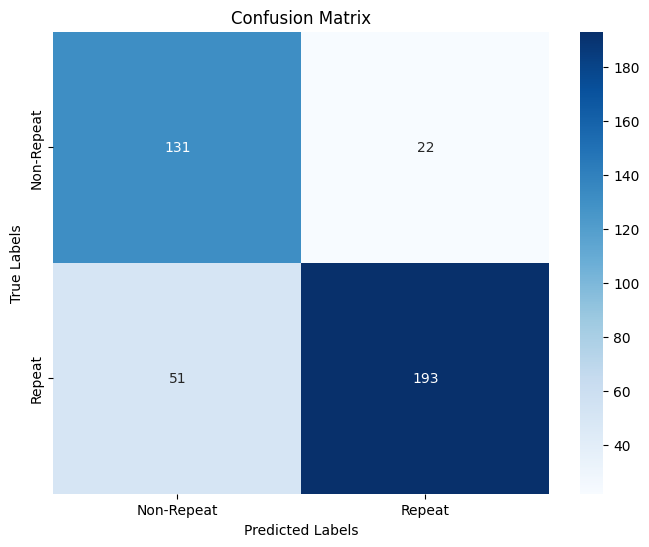

In [21]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Non-Repeat", "Repeat"], 
            yticklabels=["Non-Repeat", "Repeat"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

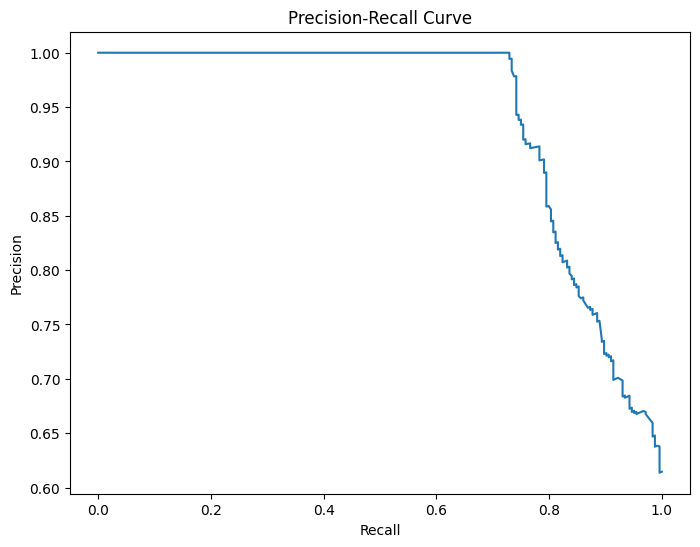

In [22]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Conclusion

There is a slightly better precision and recall output when we impute null values with means rather than medians.

The precision for the class 1 increased by 1%, signifying that the correct predictions labeled as repeat donors increased by 1%.

Additionally, the recall for class 0 increased by 2%, signifying that the actual non-repeated donors that were correctly identified by the model increased by 2%.

